Importing Libraries - Tensorflow, keras, LSTM, MinMaxScaler, Matplotlib

In [133]:
import tensorflow
from tensorflow import keras
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential
import time #helper libraries
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Read csv file

In [134]:
import pandas as pd
df3 = pd.read_csv('Amazon.csv')
df3 = df3.dropna(axis = "columns")
df3.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


Reshaping Close column - Univariate Time Series Analysis

In [135]:
import numpy as np
#Predicting Closing Prices as before
df_close = df3['Close']
df_close.shape
#Reshaping it
df_close = df_close.values.reshape(6297,1)
df_close

array([[1.95833300e+00],
       [1.72916700e+00],
       [1.70833300e+00],
       ...,
       [2.14225000e+03],
       [2.14637988e+03],
       [2.15182007e+03]])

Plotting the Close column

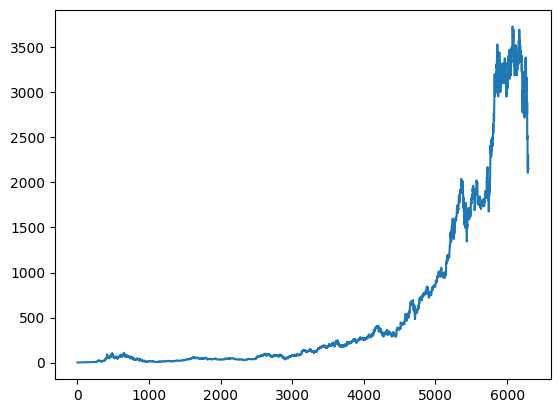

In [136]:
#Ploting it
plt.plot(df_close)
plt.show()

Check for Stationarity using ADF Test

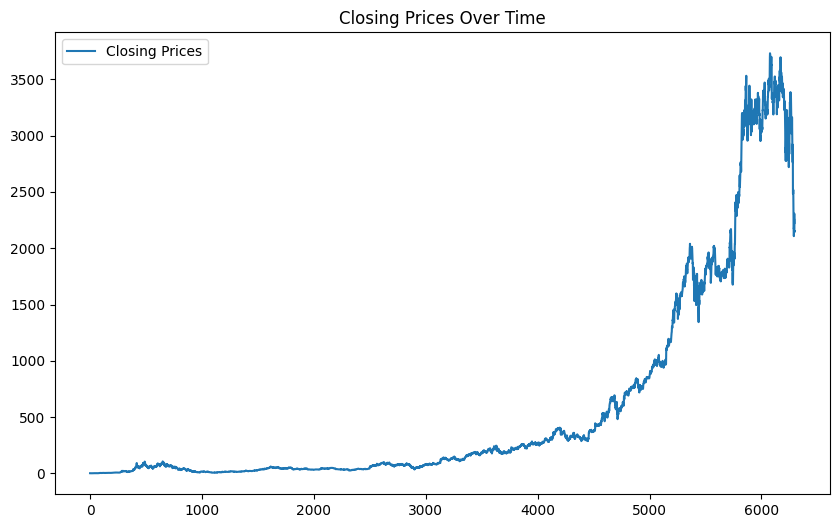

ADF Statistic: 0.09000299918031751
p-value: 0.9653718871351318
Critical Value 1%: -3.4313947113763845
Critical Value 5%: -2.862001669939781
Critical Value 10%: -2.5670157439442236
The time series is not stationary (fail to reject the null hypothesis).


In [137]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert the reshaped close prices into a pandas Series for easier manipulation
df_close_series = pd.Series(df_close.flatten(), name='Close')
# Plot the series to visually inspect seasonality and trend
plt.figure(figsize=(10, 6))
plt.plot(df_close_series, label='Closing Prices')
plt.title('Closing Prices Over Time')
plt.legend()
plt.show()
# Checking Stationarity: Augmented Dickey-Fuller (ADF) Test
result = adfuller(df_close_series)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

if result[1] <= 0.05:
    print("The time series is stationary (reject the null hypothesis).")
else:
    print("The time series is not stationary (fail to reject the null hypothesis).")

Check for Seasonality

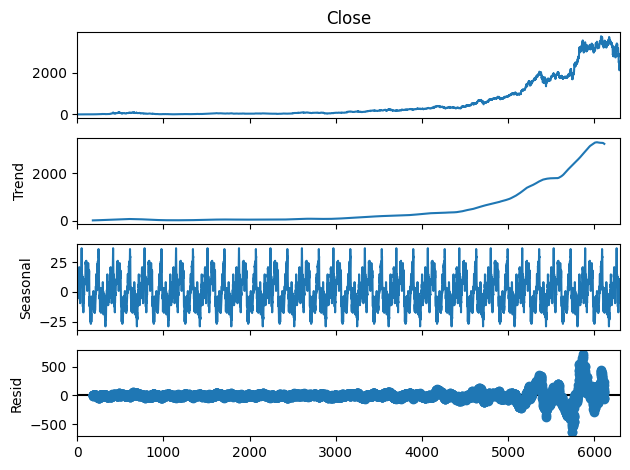

Seasonal Component:
0   -6.333598
1   -0.471971
2   -3.143363
3   -2.222933
4    0.483390
Name: seasonal, dtype: float64


In [138]:
# Checking Seasonality: Seasonal Decomposition of Time Series (STL or Classical)
# We can use 'additive' or 'multiplicative' models based on the nature of the seasonality
decomposition = seasonal_decompose(df_close_series, model='additive', period=365)

# Plot the decomposed components
decomposition.plot()
plt.show()

# Extract and analyze the seasonal component
seasonal_component = decomposition.seasonal
trend_component = decomposition.trend
residual_component = decomposition.resid

print("Seasonal Component:")
print(seasonal_component.dropna().head())

Scaling and splitting Data into Train Test

In [139]:
# Step 2: Scale the Close Prices (df_close) using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_close_scaled = scaler.fit_transform(df_close)

# Step 3: Train-Test Split
train_size = int(len(df_close_scaled) * 0.80)
test_size = len(df_close_scaled) - train_size
train, test = df_close_scaled[0:train_size, :], df_close_scaled[train_size:len(df_close_scaled), :]
print(f"Train size: {len(train)}, Test size: {len(test)}")

# Step 4: Extract corresponding seasonal component for train/test sets
# Convert seasonal component to numpy array and ensure it's the same length as df_close
seasonal_component_scaled = scaler.fit_transform(seasonal_component.values.reshape(-1, 1))

# Split the seasonal component
train_seasonal = seasonal_component_scaled[0:train_size]
test_seasonal = seasonal_component_scaled[train_size:len(df_close_scaled)]

# Step 5: Merge residual (train/test) with the seasonal component
# Combine both seasonal and scaled close prices
train_combined = train + train_seasonal
test_combined = test + test_seasonal

# Step 6: Prepare data for LSTM
# You can now use train_combined and test_combined for LSTM training
print(f"Train Combined Shape: {train_combined.shape}")
print(f"Test Combined Shape: {test_combined.shape}")

Train size: 5037, Test size: 1260
Train Combined Shape: (5037, 1)
Test Combined Shape: (1260, 1)


In [140]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_close = scaler.fit_transform(df_close)
train_size = int(len(df_close) * 0.80)
test_size = len(df_close) - train_size
train, test = df_close[0:train_size,:], df_close[train_size:len(df_close),:]
print(len(train), len(test))

5037 1260


Transforming into supervised learning data by creating input-output pairs based on a specified look_back period, optionally skipping data points with differences exceeding a defined threshold.

In [141]:
def create_dataset(dataset, look_back=1, threshold=None): 
    dataX, dataY = [], []       
    for i in range(len(dataset)-look_back-1):
        # Check the difference between the current value and the last value in the input window
        if threshold is not None:
            if np.abs(dataset[i + look_back, 0] - dataset[i + look_back - 1, 0]) > threshold:
                continue  # Skip this if the difference exceeds the threshold
        
        # Create input sequence of look_back length
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        # Add the next value as the output
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)


In [142]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train_combined, look_back,7)
testX, testY = create_dataset(test_combined, look_back,7)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [143]:
trainX

array([[[0.34519294]],

       [[0.43439164]],

       [[0.39370642]],

       ...,

       [[0.47430571]],

       [[0.58625569]],

       [[0.52349056]]])

In [144]:
'''# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back,7)
testX, testY = create_dataset(test, look_back,7)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))'''

'# reshape into X=t and Y=t+1\nlook_back = 4\ntrainX, trainY = create_dataset(train, look_back,7)\ntestX, testY = create_dataset(test, look_back,7)\n\ntrainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))\ntestX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))'

In [145]:
trainX

array([[[0.34519294]],

       [[0.43439164]],

       [[0.39370642]],

       ...,

       [[0.47430571]],

       [[0.58625569]],

       [[0.52349056]]])

LSTM Model

In [146]:
#Basic LSTM
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential
import time

# Step 2 Build Model
model = Sequential()

model.add(LSTM(units=50, input_shape=(None, 1), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))  # Use 'units' instead of 'output_dim'
model.add(Activation('relu'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
print ('compilation time : ', time.time() - start)

model.fit(trainX,trainY,batch_size=128,epochs = 80,validation_split=0.05)

compilation time :  0.009356260299682617
Epoch 1/80


C:\Users\agraw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.1772 - mae: 0.3636 - val_loss: 0.0692 - val_mae: 0.2158
Epoch 2/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0250 - mae: 0.1293 - val_loss: 0.0285 - val_mae: 0.1354
Epoch 3/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0167 - mae: 0.1057 - val_loss: 0.0125 - val_mae: 0.0900
Epoch 4/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - mae: 0.0762 - val_loss: 0.0057 - val_mae: 0.0589
Epoch 5/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mae: 0.0657 - val_loss: 0.0050 - val_mae: 0.0547
Epoch 6/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0646 - val_loss: 0.0055 - val_mae: 0.0592
Epoch 7/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0066 - mae: 0.0635 - val_loss: 0.0060 - val_mae: 0.0624
Epoch 8/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0641 - val_loss: 0.0057 - val_mae: 0.0607
Epoch 9/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0638 -

Plotting the predicted and actual series

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


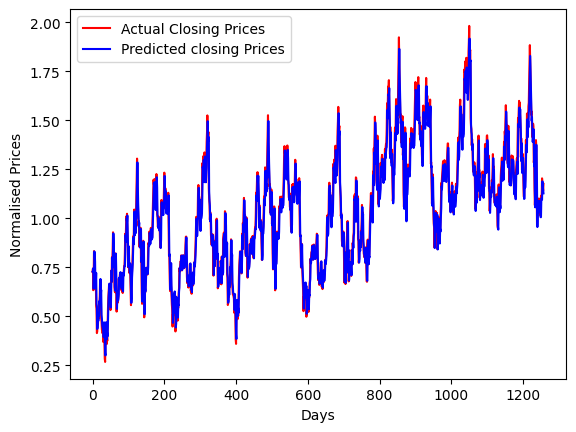

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - mae: 0.0556


In [147]:
import matplotlib.pyplot as plt
predicted_stateful = model.predict(testX)
plt.plot(testY, color = 'red',label = 'Actual Closing Prices')
plt.plot(predicted_stateful.flatten(), color = 'blue', label  = 'Predicted closing Prices')
plt.xlabel('Days')
plt.ylabel('Normalised Prices')
plt.legend(loc='best')
plt.show()

train_mae = model.evaluate(trainX,trainY,batch_size=128,verbose=1)

In [148]:
model.fit(testX,testY,batch_size=128,epochs=40,validation_split=0.05)

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0095 - mae: 0.0763 - val_loss: 0.0086 - val_mae: 0.0711
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0107 - mae: 0.0799 - val_loss: 0.0080 - val_mae: 0.0689
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0105 - mae: 0.0784 - val_loss: 0.0074 - val_mae: 0.0688
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0107 - mae: 0.0805 - val_loss: 0.0069 - val_mae: 0.0663
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0091 - mae: 0.0744 - val_loss: 0.0072 - val_mae: 0.0664
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105 - mae: 0.0794 - val_loss: 0.0080 - val_mae: 0.0685
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0096 - mae: 0.0752 - val_loss: 0.0075 - val_mae: 0.0671
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0095 - mae: 0.0754 - val_loss: 0.0074 - val_mae: 0.0668
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.009

MAE of Training Data

In [149]:
# Optionally evaluate on training data
train_mae = model.evaluate(trainX, trainY, batch_size=128, verbose=1)
print(f'Mean Absolute Error on Training Data: {train_mae}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0610
Mean Absolute Error on Training Data: [0.005967387929558754, 0.060349706560373306]


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


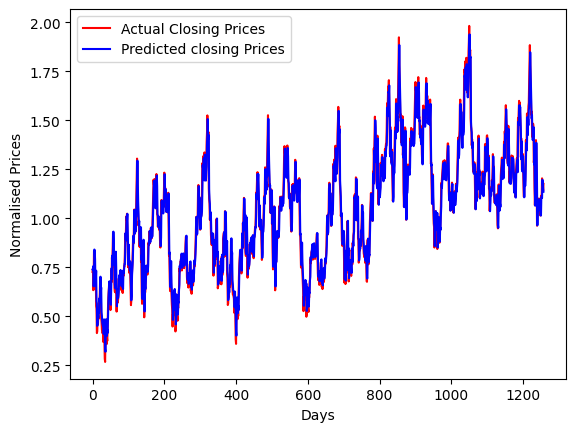

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0610
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mae: 0.0587 
Mean Absolute Error on Test Data: [0.005906424950808287, 0.059851180762052536]


In [150]:
"""**Final Predictions**"""

import matplotlib.pyplot as plt
predicted_stateful = model.predict(testX)
plt.plot(testY, color = 'red',label = 'Actual Closing Prices')
plt.plot(predicted_stateful.flatten(), color = 'blue', label  = 'Predicted closing Prices')
plt.xlabel('Days')
plt.ylabel('Normalised Prices')
plt.legend(loc='best')
plt.show()

mae = model.evaluate(trainX,
    trainY,
    batch_size=128,verbose=1)

mae = model.evaluate(testX, testY, batch_size=128, verbose=1)
print(f'Mean Absolute Error on Test Data: {mae}')
